## NEURAL NETWORKS AND DEEP LEARNING A.A. 2021/22

### Samuele Pio Lipani 2025168

### Homework 2 - Unsupervised Deep Learning

In [1]:
import matplotlib.pyplot as plt 
import numpy as np 
import pandas as pd 
import random 
import os 
from tqdm import tqdm 
import plotly.express as px

import torch
import torchvision
import torchmetrics
from torchvision import transforms
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
from torch import nn

import pytorch_lightning as pl
from pytorch_lightning import Callback
from pytorch_lightning.callbacks.early_stopping import EarlyStopping

import optuna
from optuna.integration import PyTorchLightningPruningCallback

# Dataset

## Define the dataset

One of the dataset already included in PyTorch fashion mnist will be used. This dataset do not require the definition of a custom `Dataset` class.

The FashionMNIST dataset is a colletion of clothes images. Their size is $28 \times 28$, and there is a single channel only (black and white images).

In [ ]:
# Download the data and create dataset
data_dir = 'dataset'
train_dataset = torchvision.datasets.FashionMNIST(data_dir, train=True, download=True)
test_dataset  = torchvision.datasets.FashionMNIST(data_dir, train=False, download=True)

Let's plot some random samples from the dataset. The first element of the sample is the actual image, while the second is the corresponding label.

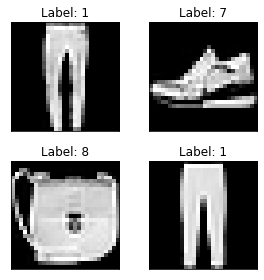

In [3]:
# Plot some sample
fig, axs = plt.subplots(2, 2, figsize=(4,4))
for ax in axs.flatten():
    img, label = random.choice(train_dataset)
    ax.imshow(np.array(img), cmap='gist_gray')
    ax.set_title('Label: %d' % label)
    ax.set_xticks([])
    ax.set_yticks([])
plt.tight_layout()

## Define the dataset transform

The only requirement for the dataset is to transform the input data to tensors of the proper shape.

In [5]:
angles = 45
gaussian_kernel = 5

train_transform = transforms.Compose([ 
    transforms.ToTensor(),
])
test_transform = transforms.Compose([
    transforms.ToTensor(),
])

# Set the train transform
train_dataset.transform = train_transform
# Set the test transform
test_dataset.transform = test_transform

## Define the dataloader

The dataloader allows to easily create batch of data, in this case a batch size of 256 is set, and data shuffling for the training dataset is also enabled.

In [7]:
# divide in training an validation dataset with percentage 80%-20%

train_p = 0.8
train_el = len(train_dataset)
n_train_el = int(train_p*train_el) 
n_val_el = train_el - n_train_el
n_test_el  = len(test_dataset)

print("Elements in Train set:",      n_train_el)
print("Elements in Validation set:", n_val_el)
print("Elements in Test set:",       n_test_el)


train_set, val_set = torch.utils.data.random_split(train_dataset, 
                                                         [50000, 10000])
train_dataload = DataLoader(train_set, batch_size=256, shuffle=True)

val_dataload = DataLoader(val_set, batch_size=256, shuffle=False)

test_dataload = DataLoader(test_dataset, batch_size=256, shuffle=False)

batch_data, batch_labels = next(iter(train_dataload))
print(f"Train batch shape")
print(f"\t Data: {batch_data.shape}")
print(f"\t Labels: {batch_labels.shape}")

batch_data, batch_labels = next(iter(test_dataload))
print(f"Test batch shape")
print(f"\t Data: {batch_data.shape}")
print(f"\t Labels: {batch_labels.shape}")

Elements in Train set: 48000
Elements in Validation set: 12000
Elements in Test set: 10000
Train batch shape
	 Data: torch.Size([256, 1, 28, 28])
	 Labels: torch.Size([256])
Test batch shape
	 Data: torch.Size([256, 1, 28, 28])
	 Labels: torch.Size([256])


#### Autoencoder
##### Methods

A convolutionala autoencoder, particularly useful in case of images, is used and implemented. An autoencoder is made of two main structures:
- encoeder, which takes the input and transforms it in a limited series of parameters $\{\xi_i\}_{i=1,...,N}$ which captures the characteristics of that input, and the space where these parameters lives is called encoded space;
- decoder has the same structure of the encoder but mirrored. It transforms points in the encoded space back into samples of the same type of the input.

In order to avoid gradient vanishing problems Relu will be exploited as activation function. A regularization procedure is also implemented for generalizing out of the training set.
L2 regularization is used, which consists of adding a penalty in the loss proportional to the 2-norm of the parameters, i.e. weights and biases.

Two optimizers are going to be exploited: 
- The stochastic gradient descent with momentum, which is the really basic algorithm for optimization. The addition of the momentum, i.e. the memory of previous steps, really helps to go out of local minima and speeds up convergence;
- the Adam algorithm, adaptive moment estimator, a more advanced algorithm that uses estimations of first and second moments of the gradient to adapt the learning rate of each weight of the neural network.

In [8]:
class AutoEncoder(pl.LightningModule):

    def __init__(self, trial):
        super().__init__()
        encoded_space_dim = trial.suggest_int('encoded_space_dim', 2, 20)
        self.trial = trial
        
        # Encoder
        self.encoder = nn.Sequential(
            # First convolutional layer
            nn.Conv2d(1, 8, kernel_size=3, padding=1, stride=2),
            nn.ReLU(),
            # Second convolutional layer
            nn.Conv2d(8, 16, kernel_size=3, padding=1, stride=2),
            nn.ReLU(),
            # Third convolutional layer
            nn.Conv2d(16, 32, kernel_size=3, padding=0, stride=2),
            nn.ReLU(),
            # Flatten layer
            nn.Flatten(start_dim=1),
            # First linear layer
            nn.Linear(288, 64),
            nn.ReLU(),
            # Second linear layer (output layer)
            nn.Linear(64, encoded_space_dim))

        # Decoder
        self.decoder =  nn.Sequential(
            # First linear layer
            nn.Linear(encoded_space_dim, 64),
            nn.ReLU(True),
            # Second linear layer
            nn.Linear(64, 3*3*32), # (64, 288)
            nn.ReLU(True),
            # Unflatten
            nn.Unflatten(dim=1, unflattened_size=(32, 3, 3)),
            # First transposed convolution
            nn.ConvTranspose2d(32, 16, kernel_size=3, output_padding=0, stride=2),
            nn.ReLU(True),
            # Second transposed convolution
            nn.ConvTranspose2d(16, 8, kernel_size=3, output_padding=1, padding=1, stride=2),
            nn.ReLU(True),
            # Third transposed convolution
            nn.ConvTranspose2d(8, 1, kernel_size=3, output_padding=1, padding=1, stride=2),
            # To obtain an output in [0,1]
            nn.Sigmoid())

        self.configure_loss(loss_fn)
        
    def forward(self, x):
        # in lightning, forward defines the prediction/inference actions
        embed = self.encoder(x)
        return embed

    def training_step(self, batch, batch_idx):
        # training_step defined the train loop. Independent from forward step
        x, y = batch
        z = self.encoder(x)
        x_h = self.decoder(z)
        loss = self.loss_fn(x_h, x)
        self.log('train_loss', loss)
        return loss
    
    def validation_step(self, batch, batch_idx, loss_name='validation_loss'):
        x, y = batch
        z = self.encoder(x)
        x_h = self.decoder(z)
        val_loss = self.loss_fn(x_h, x)
        self.log(loss_name, val_loss, prog_bar=True)
        return val_loss
    
    def test_step(self, batch, batch_idx):
        self.validation_step(batch, batch_idx, loss_name='test_loss')

    def configure_optimizers(self):
        opt = self.trial.suggest_categorical('optimizer', ['SGD', 'Adam'])
        lr = self.trial.suggest_loguniform('learning_rate', 1e-5, 1e-3)
        wd = self.trial.suggest_loguniform('weight_decay', 1e-5, 1e-3)
        if opt=='Adam':
            optim = torch.optim.Adam(self.parameters(), lr=lr, 
                                        weight_decay=wd)
        elif opt=='SGD':
            optim = torch.optim.SGD(self.parameters(), lr=lr, 
                                        momentum=0.9, weight_decay=wd)
            
        return optim
    
    def configure_loss(self, loss_fn):
        self.loss_fn = loss_fn

##### Hyperparameters optimization

After creating the model that will encode and decode data in order to give a latent representation of them it's time to evaluate it on a set of parameters. <br>
For evaluating the best model over a set of parameters optuna pytorch tool will be used. It is based on Bayesian optimization meaning that the algorithm moves in the parameters space for each iteration to a parameters set (point in that space) that should work better than the previous one. Hyperparameters that will be optimized are:
- weight of the L2 regularization;
- optimizer, between the Adam and the SGD with momentum;
- learning rate of the optimizer;
- encoded space dimension;

In [8]:
class MetricsCallb(Callback):
    """
    PyTorch Lightning metric callback.
    """

    def __init__(self):
        super().__init__()
        self.metrics = []

    def on_validation_end(self, trainer, pl_module):
        self.metrics.append(trainer.callback_metrics)

perc_test_examples = 1
def objective(trial):
    # Function to optimize from optuna
    checkpoint_callback = pl.callbacks.ModelCheckpoint(
        os.path.join(model_dir, "trial_{}".format(trial.number)), monitor="validation_loss"
    )

    metrics_callback = MetricsCallb()
    
    trainer = pl.Trainer(
        logger=False,
        checkpoint_callback=checkpoint_callback,
        max_epochs=50,
        gpus=1 if torch.cuda.is_available() else None,
        callbacks=[metrics_callback, 
                   PyTorchLightningPruningCallback(trial, monitor="validation_loss")],
    )

    model = AutoEncoder(trial)
    trainer.fit(model, train_dataload, val_dataload)
    
    return metrics_callback.metrics[-1]["validation_loss"].item()

In [ ]:
direc = os.getcwd()
model_dir = os.path.join(direc, "result")
loss_fn = torch.nn.MSELoss()

pruner = optuna.pruners.MedianPruner()
study = optuna.create_study(direction="minimize", pruner=pruner)
study.optimize(objective, n_trials=100, timeout=None)

After 100 trials the optimum model has a value of 0.01427497062832117 for the loss:

Best trial params: 
- encoded_space_dim: 10
- optimizer: Adam
- learning_rate: 0.0009894374245834558
- weight_decay: $1.7170482301081654 \cdot 10^{-5}$


In [13]:
optuna.visualization.plot_optimization_history(study, target_name='Validation loss')

In [14]:
optuna.visualization.plot_intermediate_values(study)

Validation loss starts quite soon to decrease as it can be seen from the first and second figure, after just about ten trials. When the number of trials increases the intermediate value for loss tends to converge to the asymptote region after a couple of epochs. The minimum validation loss reached is $\approx 0.01$ that, in the case of non representative validation samples could be a symptom of overfitting. Overfitting will be detected eventually when testing the best model on the whole test set, k-fold is not implemented since the number of images is greater than the first tast, hw1, and they could be statistically enough for the actual task.<br>
It is really evident from teh result that the Adam is the best optimizer for this task. The regularization has a very low value, and the learning rate is really near the higher bound. This might suggest that a new search should have been implemented, increasing the higher bound on the learning rate. What is really interesting is, however, that the encoded space dimension $N = 10$ is the one performing better. This suggests that $N = 10$ is a sufficient dimension, and further enlargements are not needed.

Define now the autoencoder with the best hyperparameters

In [76]:
class AutoEncoder1(pl.LightningModule):

    def __init__(self, encoded_space_dim):
        super().__init__()
        # Encoder
        self.encoder = nn.Sequential(
            # First convolutional layer
            nn.Conv2d(1, 8, kernel_size=3, padding=1, stride=2),
            nn.ReLU(),
            # Second convolutional layer
            nn.Conv2d(8, 16, kernel_size=3, padding=1, stride=2),
            nn.ReLU(),
            # Third convolutional layer
            nn.Conv2d(16, 32, kernel_size=3, padding=0, stride=2),
            nn.ReLU(),
            # Flatten layer
            nn.Flatten(start_dim=1),
            # First linear layer
            nn.Linear(288, 64),
            nn.ReLU(),
            # Second linear layer (output layer)
            nn.Linear(64, encoded_space_dim)
        )
        # Decoder
        self.decoder =  nn.Sequential(
            # First linear layer
            nn.Linear(encoded_space_dim, 64),
            nn.ReLU(True),
            # Second linear layer
            nn.Linear(64, 3*3*32), # (64, 288)
            nn.ReLU(True),
            # Unflatten
            nn.Unflatten(dim=1, unflattened_size=(32, 3, 3)),
            # First transposed convolution
            nn.ConvTranspose2d(32, 16, kernel_size=3, output_padding=0, stride=2),
            nn.ReLU(True),
            # Second transposed convolution
            nn.ConvTranspose2d(16, 8, kernel_size=3, output_padding=1, padding=1, stride=2),
            nn.ReLU(True),
            # Third transposed convolution
            nn.ConvTranspose2d(8, 1, kernel_size=3, output_padding=1, padding=1, stride=2),
            # To obtain an output in [0,1]
            nn.Sigmoid()
        )
    def forward(self, x):
        embed = self.encoder(x)
        return embed

    def training_step(self, batch, batch_idx):
        x, y = batch
        z = self.encoder(x)
        x_h = self.decoder(z)
        loss = self.loss_fn(x_h, x)
        self.log('train_loss', loss)
        return loss
    
    def validation_step(self, batch, batch_idx, loss_name='validation_loss'):
        x, y = batch
        z = self.encoder(x)
        x_h = self.decoder(z)
        val_loss = self.loss_fn(x_h, x)
        self.log(loss_name, val_loss, prog_bar=True)
        return val_loss
    
    def test_step(self, batch, batch_idx):
        self.validation_step(batch, batch_idx, loss_name='test_loss')

    def configure_optimizers(self):
        optim = torch.optim.Adam(self.parameters(), lr=0.0009894374245834558, weight_decay=1.7170482301081654e-05)
        return optim
    
    def configure_loss(self, loss_fn):
        self.loss_fn = loss_fn

In [77]:
# Set the random seed for reproducible results
torch.manual_seed(1999)
np.random.seed(1999)

encoded_space_dim = 10
auto_encoder = AutoEncoder1(encoded_space_dim=encoded_space_dim)

#### Training the autoencoder wit the best set of hyperparameters

In [ ]:
# Loss function
loss_fn = torch.nn.MSELoss()
# Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')

# Move both the encoder and the decoder to the selected device
auto_encoder.to(device)
auto_encoder.configure_loss(loss_fn)

trainer = pl.Trainer(gpus=1, max_epochs=40, progress_bar_refresh_rate=10, 
                     callbacks=[EarlyStopping(monitor='validation_loss')])
trainer.fit(auto_encoder, train_dataload, val_dataload)

Epoch 39: 100%|██████████| 236/236 [00:06<00:00, 35.24it/s, loss=0.016, v_num=26, validation_loss=0.0171]

#### Testing the autoencoder on the test dataset

In [ ]:
trainer.test(auto_encoder, test_dataload)

# Saving the model
trainer.save_checkpoint("best_model.ckpt")

Testing: 100%|██████████| 40/40 [00:00<00:00, 43.52it/s]

DATALOADER:0 TEST RESULTS
{'test_loss': 0.016978023573756218}

An example of reconstruction is the following.

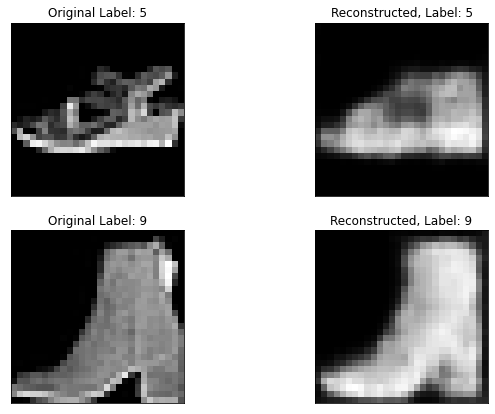

In [109]:
fig, axes = plt.subplots(2, 2, figsize=(10,7))
for ax in axes:
    imag, label = random.choice(test_dataset)
    imag1 = imag[0]
    with torch.no_grad():
        encoded_img  = auto_encoder.encoder(imag.unsqueeze(0))
        decoded_img  = auto_encoder.decoder(encoded_img)
    
    ax[0].imshow(np.array(imag1), cmap='gray')
    ax[0].set_title('Original Label: %d' % label)
    ax[0].set_xticks([])
    ax[0].set_yticks([])

    ax[1].imshow(decoded_img.squeeze().cpu().numpy(), cmap='gray')
    ax[1].set_title('Reconstructed, Label: %d' % label)
    ax[1].set_xticks([])
    ax[1].set_yticks([])

As it can be seen details are lost during the autoencoding procedure while edges are pretty well reconstructed.

#### Denoiser
##### Methods

The denoiser has the same architecture of the autoencoder presented before. The only difference is that, before giving the images in input to the encoder some random noise is applied.
Different types of noises can be used, in particular Gaussian noise $\eta \sim N(\mu,\sigma)$ is used, which parameters are gaussianly distributed, i.e. $\mu \sim N(0,1)$, $\sigma \sim N(0.5,0.5)$. In this way the network is trained to reconstruct different variations of white noise. The same hyperparameters inferred in the previous part for the best model were considered. 

In [112]:
class Denoiser(pl.LightningModule):

    def __init__(self, encoded_space_dim):
        super().__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=3, padding=1, stride=2),
            nn.ReLU(),
            nn.Conv2d(8, 16, kernel_size=3, padding=1, stride=2),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, padding=0, stride=2),
            nn.ReLU(),
            nn.Flatten(start_dim=1),
            nn.Linear(288, 64),
            nn.ReLU(),
            nn.Linear(64, encoded_space_dim)
        )
        # Decoder
        self.decoder =  nn.Sequential(
            nn.Linear(encoded_space_dim, 64),
            nn.ReLU(True),
            nn.Linear(64, 3*3*32),
            nn.ReLU(True),
            nn.Unflatten(dim=1, unflattened_size=(32, 3, 3)),
            nn.ConvTranspose2d(32, 16, kernel_size=3, output_padding=0, stride=2),
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 8, kernel_size=3, output_padding=1, padding=1, stride=2),
            nn.ReLU(True),
            nn.ConvTranspose2d(8, 1, kernel_size=3, output_padding=1, padding=1, stride=2),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        embed = self.encoder(x)
        return embed

    def training_step(self, batch, batch_idx):
        x, y = batch
        # Apply noise to x
        mean = torch.randn(1).to(device) * 1
        std = torch.randn(1).to(device) * 0.5 + 0.5
        noisy_x = x + torch.randn(x.size()).to(device) *std + mean
        z = self.encoder(noisy_x)
        x_h = self.decoder(z)
        loss = self.loss_fn(x_h, x)
        self.log('train_loss', loss)
        return loss
    
    def validation_step(self, batch, batch_idx, loss_name='validation_loss'):
        x, y = batch
        # Apply noise to x
        mean = torch.randn(1).to(device) * 1
        std = torch.randn(1).to(device) * 0.5 + 0.5
        noisy_x = x + torch.randn(x.size()).to(device) *std + mean
        z = self.encoder(noisy_x)
        x_hat = self.decoder(z)
        val_loss = self.loss_fn(x_hat, x)
        self.log(loss_name, val_loss, prog_bar=True)
        return val_loss
    
    def test_step(self, batch, batch_idx):
        self.validation_step(batch, batch_idx, loss_name='test_loss')

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=0.0009894374245834558, weight_decay=1.7170482301081654e-05)
        return optimizer
    
    def configure_loss(self, loss_fn):
        self.loss_fn = loss_fn

In [113]:
# Set the random seed for reproducible results
torch.manual_seed(1999)
np.random.seed(1999)

encoded_space_dim = 10
denoise = Denoiser(encoded_space_dim=encoded_space_dim)

loss_fn = torch.nn.MSELoss()
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')

# Move both the encoder and the decoder to the selected device
denoise.to(device)
denoise.configure_loss(loss_fn)

Selected device: cuda


In [ ]:
# Training
train = pl.Trainer(gpus=1, max_epochs=30, progress_bar_refresh_rate=20, 
                     callbacks=[EarlyStopping(monitor='validation_loss')])
train.fit(denoise, train_dataload, val_dataload)

Epoch 26: 100%|██████████| 236/236 [00:07<00:00, 31.25it/s, loss=0.0322, v_num=28, validation_loss=0.0316]

In [116]:
train.test(denoise, test_dataload)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 100%|██████████| 40/40 [00:01<00:00, 40.23it/s]--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.03103485144674778}
--------------------------------------------------------------------------------
Testing: 100%|██████████| 40/40 [00:01<00:00, 39.53it/s]


[{'test_loss': 0.03103485144674778}]

Some examples of the noising denoising procedure are reported in the following figure.

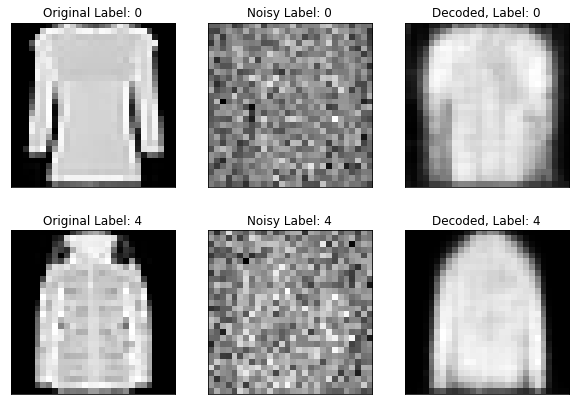

In [120]:
fig, axes = plt.subplots(2, 3, figsize=(10,7))
for ax in axes:
    # random.choice allows to randomly sample from a list-like object (basically anything that can be accessed with an index, like our dataset)
    imag, label = random.choice(test_dataset)
    imag1 = imag[0]
    ax[0].imshow(np.array(imag1), cmap='gist_gray')
    ax[0].set_title('Original Label: %d' % label)
    ax[0].set_xticks([])
    ax[0].set_yticks([])
    # adding random noise to the image chosen randomly
    imag1 = imag1 + np.random.normal(0, 1, size=imag1.shape)
    ax[1].imshow(np.array(imag1), cmap='gist_gray')
    ax[1].set_title('Noisy Label: %d' % label)
    ax[1].set_xticks([])
    ax[1].set_yticks([])
    
    imag = imag.unsqueeze(0)
    denoise.eval()
    with torch.no_grad():
        encoded_img  = denoise.encoder(imag)
        decoded_img  = denoise.decoder(encoded_img)
    ax[2].imshow(np.array(decoded_img.cpu()[0][0]), cmap='gist_gray')
    ax[2].set_title('Decoded, Label: %d' % label)
    ax[2].set_xticks([])
    ax[2].set_yticks([])

The denoiser implemented above is able to reproduce images coherently even with some error as it can be seen in the previous picture. Its test loss is $\approx 0.03$.

#### Fine tuning

Methods of transfer learning will be applied: all the network up to the encoded space are kept fixed, a fully-connected layer and a readout layer will be added on top of it. 
The parameters of the Encoder are "frozen", i.e. learning is not performed on that part of the network. New layers are instead trained, which consist of:
- an hidden layer with 64 neurons;
- the output layer with 10 neurons.

As activation function a ReLU is used and a negative log likelihood loss, which is optimal when there are  log-probabilities of the different input classes as output of the network, as in this case. What is really important is that, even though the full network has about $26300$ parameters only $1300$ of them have to be trained, speeding up the task.

In [30]:
class Classifier(pl.LightningModule):

    def __init__(self, encoded_space_dim, pretrained):
        super().__init__()
        self.encoder = pretrained.encoder
        self.fine_tune =  nn.Sequential(
            nn.Linear(encoded_space_dim, 64),
            nn.ReLU(True),
            nn.Linear(64, 10),
            nn.LogSoftmax()
        )
        self.accuracy = torchmetrics.Accuracy()
        
    def forward(self, x):
        x = self.encoder(x)
        x = self.fine_tune(x)
        return x

    def training_step(self, batch, batch_idx):
        x, y = batch
        z = self.forward(x)
        loss = self.loss_fn(z, y)
        self.log('train_loss', loss)
        return loss
    
    def validation_step(self, batch, batch_idx, loss_name='validation_loss'):
        x, y = batch
        z = self.forward(x)
        val_loss = self.loss_fn(z, y)
        self.log(loss_name, val_loss, prog_bar=True)
        return val_loss
    
    def test_step(self, batch, batch_idx):
        x, y = batch
        z = self.forward(x)
        self.log('accuracy', self.accuracy(z, y), prog_bar=True)
        return self.accuracy(z, y)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=0.0009894374245834558, weight_decay=1.7170482301081654e-05)
        return optimizer
    
    def configure_loss(self, loss_fn):
        self.loss_fn = loss_fn

In [ ]:
pretrained = AutoEncoder1.load_from_checkpoint(checkpoint_path="best_model.ckpt", encoded_space_dim=encoded_space_dim)
fine_tune = Classifier(encoded_space_dim, pretrained)

# Freeze params
for param in fine_tune.encoder.parameters():
    param.requires_grad = False

loss_loglike = torch.nn.NLLLoss()
fine_tune.configure_loss(loss_loglike)
fine_tune.to(device)

# Training
trainer = pl.Trainer(gpus=1, max_epochs=30, progress_bar_refresh_rate=20, 
                     callbacks=[EarlyStopping(monitor='validation_loss')])
trainer.fit(fine_tune, train_dataload, val_dataload)

Epoch 27: 100%|██████████| 236/236 [00:07<00:00, 32.31it/s, loss=0.428, v_num=20, validation_loss=0.463]

In [33]:
# Test accuracy
trainer.test(fine_tune, test_dataload)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 100%|██████████| 40/40 [00:01<00:00, 37.59it/s]--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'accuracy': 0.8241000175476074}
--------------------------------------------------------------------------------
Testing: 100%|██████████| 40/40 [00:01<00:00, 36.99it/s]


[{'accuracy': 0.8241000175476074}]

30 epochs were given for testing for computational reasons. Even though the small number of steps an accuracy of 0.82 was reached, where accuracy is just the number of corrected  classified samples over the number of total samples.
The latter is quite impressive compared to the accuracy achieved in the first homework, where all the hyperparameters were tuned and the whole network was trained to perform the classification task, reaching an accuracy of 0.86 (a small number of epochs does not allow a high accuracy on the test set probably due also to overfitting). Transfer learning is a very powerful technique, since applying just a hidden layer and the output layer to a pre-trained encoder produced an high
test accuracy compared to the first homework one.

#### Encoded space, latent space, analysis

Let's try to inspect the latent space and see how variables have been encoded by the Convolutional AutoEncoder. In order to visualize them dimensionality reduction has been performed:
- PCA: the Principal Components Analysis is an unsupervised algorithm  It is commonly used for dimensionality reduction by projecting each data point onto only the first few principal components to obtain lower-dimensional data while preserving as much of the data's variation as possible. Points however are mixed up, despite some clusters can be identified thanks to the color which denotes their true label.
- t-SNE: the t-Distributed stochastic Neighbor Embedding is a non-linear transformation that allows to reduce the data dimensionality, via the assignation of larger probabilities to pairs of objects that might share features (e.g. are “close”) in the original space. Finally it reduces the dimensionality to the one requested, trying then to minimize the Kullblach-Leibler’s divergence between the pdf over pairs constructed in the new low-dimensional space and the original one. In this way, points that were sharing features in the original space are now clustered, thus (visually) close in the new space. Images form clusters that are separate from each other but some exceptions can occurr.

In [51]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [53]:
# Load network parameters
auto_enc = AutoEncoder1.load_from_checkpoint("best_model.ckpt", encoded_space_dim=encoded_space_dim).to(device)

# latent representation of the test samples
encoded_samples = []
enc_aut = np.zeros(encoded_space_dim+1)
for sample in tqdm(test_dataset):
    imag = sample[0].unsqueeze(0).to(device)
    label = sample[1]
    # Encode image
    auto_enc.eval()
    with torch.no_grad():
        encoded_img  = auto_enc.encoder(imag)
    # Append to list
    encoded_img = encoded_img.flatten().cpu().numpy()
    encoded_sample = {f"Enc. Variable {i}": enc for i, enc in enumerate(encoded_img)}
    encoded_sample['label'] = label
    encoded_samples.append(encoded_sample)
    enc_aut = np.vstack((enc_aut, np.hstack((encoded_img, label))))

100%|██████████| 10000/10000 [00:09<00:00, 1034.86it/s]


In [54]:
encoded_samples = pd.DataFrame(encoded_samples)
# PCA
n_comp = 2
pca = PCA(n_components=n_comp)
pca.fit(encoded_samples.iloc[:,0:encoded_space_dim])
columns = [f'Enc. Variable {i}' for i in range(n_comp)]
compressed_samples = pd.DataFrame( pca.transform(encoded_samples.iloc[:,0:encoded_space_dim]), columns=columns)
fig = px.scatter(compressed_samples, x='Enc. Variable 0', y='Enc. Variable 1', 
        color=encoded_samples.label.astype(str), opacity=0.8)
fig.show()

In [55]:
encoded_samples = pd.DataFrame(encoded_samples)
# tsne
tsne = TSNE(n_components=n_comp)
tsne.fit(encoded_samples.iloc[:, 0:encoded_space_dim])
columns = [f'Enc. Variable {i}' for i in range(n_comp)]
compressed_samples = pd.DataFrame( tsne.fit_transform(encoded_samples.iloc[:,0:encoded_space_dim]), columns=columns)
fig = px.scatter(compressed_samples, x='Enc. Variable 0', y='Enc. Variable 1', 
        color=encoded_samples.label.astype(str), opacity=0.8)
fig.show()

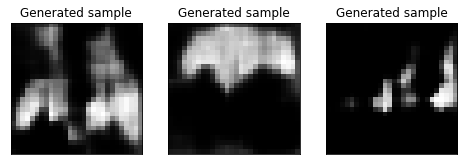

In [121]:
# Generation of new samples
# Plot some sample
fig, ax = plt.subplots(1, 3, figsize=(8,6))
# random.choice allows to randomly sample from a list-like object (basically anything that can be accessed with an index, like our dataset)
for i in range(3):
    imag, label = random.choice(test_dataset)
    imag1 = img[0]
    with torch.no_grad():
        encoded_img  = auto_enc.encoder(imag.unsqueeze(0).to(device))
        decoded_img  = auto_enc.decoder(20*torch.randn_like(encoded_img).to(device) )

    ax[i].imshow(decoded_img.squeeze().cpu().numpy(), cmap='gist_gray')
    ax[i].set_title('Generated sample')
    ax[i].set_xticks([])
    ax[i].set_yticks([])

Generated samples from the autoencoder latent space by a gaussian distribution don't seem to represent well the actual images.

#### GAN

Generative Adversarial Networks have been introduced to somehow specifically weight some portions of input, which might have high saliency in its semantic, though having a small MSE loss when “missed”. The key idea is to build a good generative model of the data whose task is to fool a supervised classifier which must tell whether the image has been artificially generated or is coming from the original dataset (BinaryCrossEntropy loss function). The input for the Generator is some noise vector Normally distributed (whose size is 64), whereas the input for the Discriminator is a 28 ×28 image, which is flattened to a 784-unit Layer. 

The architecture for the Generator is:
- Input Layer: 64 units, LeakyReLU activation;
- First Linear Layer: 256 units, LeakyReLU activation; 
- Second Linear Layer: 512 units, LeakyReLU activation;
- Third Linear Layer: 1024 units, LeakyReLU activation;
- Output Layer: 784 units, Tanh activation;

Whereas for the Discriminator:
- Input Layer: 784 units, LeakyReLU activation;
- First Linear Layer: 1024 units, LeakyReLU activation;
- Second Linear Layer: 512 units, LeakyReLU activation;
- Third Linear Layer: 256 units, LeakyReLU activation;
- Output Layer: 1 unit, with Sigmoid activation;

Note as the Discriminator’s Output Layer has a Sigmoid activation function and is composed by a single unit. The latter is a constraint by the nature of the problem. Specifically for this task, samples are normalized via Normalize((0.500,),(0.500,)) otherwise the two losses do not converge, as experencied in many trials. The expected, and obtained, behavior of the loss is indeed the one depicted in the last figure, where initially the Generator is not able to build good samples and the Discriminator has easy life. As training evolves, the Generator is able to generate more and more high-quality  mages which fool the Discriminator that in the meanwhile has in turn been trained, finally reaching a an equilibrium value for such process. 

In [7]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
ill = 64 # latent vector size
k = 1 # number of steps to apply to the discriminator
# normalization does not need to occur as in the previous homework and mu = 0.500 and sigma = 0.500
GAN_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.500,), (0.500,))
])

# Define train dataloader
train_dataload = DataLoader(train_dataset, batch_size=512, shuffle=True)
# Define test dataloader
test_dataload = DataLoader(test_dataset, batch_size=512, shuffle=False)

# Set the train transform
train_dataset.transform = GAN_transforms
# Set the test transform
test_dataset.transform = GAN_transforms

In [8]:
class Generator(nn.Module):
    
    def __init__(self, ill):
        super().__init__()
        """
        ill : the number of input features for the first linear layer.
        """
        self.ill = ill
        self.main = nn.Sequential(
            nn.Linear(self.ill, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, 784),
            nn.Tanh(),
        )
        
    def forward(self, x):
        return self.main(x).view(-1, 1, 28, 28)

In [9]:
class Discriminator(nn.Module):
    def __init__(self):
        """
        Image is 28x28
        """
        super(Discriminator, self).__init__()
        self.n_input = 784
        self.main = nn.Sequential(
            nn.Linear(self.n_input, 1024),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )
        
    def forward(self, x):
        x = x.view(-1, 784)
        return self.main(x)

In [10]:
generator = Generator(ill).to(device)
discriminator = Discriminator().to(device)
# since generator and discriminator act in different moments two optimizers are needed
optim_g = torch.optim.Adam(generator.parameters(), lr=0.0002)
optim_d = torch.optim.Adam(discriminator.parameters(), lr=0.0002)

# loss function has to be binary since the result image can be either TRUE or FAKE
GAN_loss = nn.BCELoss()

In [11]:
losses_g = [] # to store generator loss after each epoch
losses_d = [] # to store discriminator loss after each epoch
images   = [] # to store images generatd by the generator


# these functions will return vectors with shape as the batch size to create real labels (1s)
def label_real(size):
    data = torch.ones(size, 1)
    return data.to(device)

# to create fake labels (0s)
def label_fake(size):
    data = torch.zeros(size, 1)
    return data.to(device)

# function to create the noise vector useful for the generation of new images
def create_noise(sample_size, nz):
    return torch.randn(sample_size, nz).to(device)

# function to train the discriminator network
def train_discriminator(optimizer, data_real, data_fake):
    b_size = data_real.size(0)
    real_label = label_real(b_size)
    fake_label = label_fake(b_size)
    optimizer.zero_grad()
    
    # see ifthe discriminator is able to detect real images
    out_real = discriminator(data_real)
    loss_real = GAN_loss(out_real, real_label)
    
    #see if the discriminator is able to detect fake images
    out_fake = discriminator(data_fake)
    loss_fake = GAN_loss(out_fake, fake_label)
    
    #propagate the loss
    loss_real.backward()
    loss_fake.backward()
    
    optimizer.step()
    
    del out_real, out_fake, real_label, fake_label
    
    return loss_real + loss_fake

# function to train the generator network
def train_generator(optimizer, data_fake):
    b_size = data_fake.size(0)
    real_label = label_real(b_size)
    optimizer.zero_grad()
    
    # see if discriminator was able to detect fake images
    out = discriminator(data_fake) 
    loss = GAN_loss(out, real_label)
    loss.backward()
    
    optimizer.step()
    
    del out, real_label
    
    return loss

In [12]:
# create the noise vector
noise = create_noise(64, ill)
epochs = 500

discriminator.train()
generator.train()

for epoch in tqdm(range(epochs)):
    loss_g = 0.0
    loss_d = 0.0
    cnt = 0
    
    for image_batch, _ in train_dataload:
        
        image_batch = image_batch.to(device)
        batch_size = len(image_batch)
        
        # run the discriminator for k number of steps
        for step in range(k):
            data_fake = generator(create_noise(batch_size, ill)).detach()
            data_real = image_batch
            # train the discriminator network
            loss_d += train_discriminator(optim_d, data_real, data_fake)

            
        data_fake = generator(create_noise(batch_size, ill))
        
        # train the generator network
        loss_g += train_generator(optim_g, data_fake)
        cnt += 1
        
        del data_fake, data_real, image_batch
    
    # the following lines avoid filling the RAM with tensors and gradients that are not used anymore 
    loss_g = loss_g.detach()
    loss_d = loss_d.detach()  
    
    # create the final fake image for the epoch
    generated_img = generator(noise).cpu().detach()
    
    # make the images as grid
    generated_img = make_grid(generated_img)
    images.append(generated_img)
    
    epoch_loss_g = loss_g/cnt # total generator loss for the epoch
    epoch_loss_d = loss_d/cnt # total discriminator loss for the epoch
    
    losses_g.append(epoch_loss_g)
    losses_d.append(epoch_loss_d)

print("Epoch 500 gives as losses for generator: ",losses_g[-1].cpu().numpy(),"\nAnd for discriminator: ", 
losses_d[-1].cpu().numpy())

100%|██████████| 500/500 [1:09:49<00:00,  8.38s/it]

Epoch 500 gives as losses for generator:  1.2640755 
And for discriminator:  1.0686798


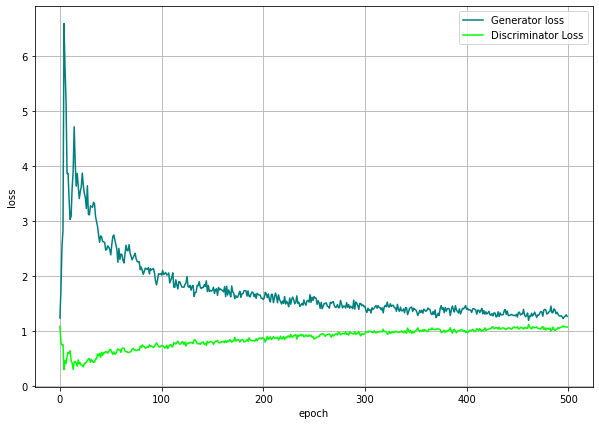

In [13]:
# plot the generator and discriminator loss
plt.figure(figsize=(10,7))
plt.plot(losses_g, label = 'Generator loss', color = "teal")
plt.plot(losses_d, label = 'Discriminator Loss', color = "lime")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.grid()
plt.legend();

In [ ]:
import matplotlib.animation as animation
fig, ax = plt.subplots()

im_gen = [images[i][0] for i in range(500)]
im_dis = [images[i][0] for i in range(500)]
ims_gen = []
ims_dis = []
for i in im_gen:
    imm_gen = ax.imshow(i, animated = True)
    ims_gen.append([imm_gen])
for j in im_dis:
    imm_dis = ax.imshow(j, animated = True)
    ims_dis.append([imm_dis])
ani_gen = animation.ArtistAnimation(fig, ims_gen, interval=1, blit=True,
                                repeat_delay=1000)
ani_dis = animation.ArtistAnimation(fig, ims_dis, interval=1, blit=True,
                                repeat_delay=1000)

ani_gen.save("gen.gif")
ani_dis.save("dis.gif")
# gif doesn't work for a jupyter cell therefore it's nice to save it as a.gif and show it later

In the same repository uploaded on moodle there is the animated plot of the generator and discriminator over the number of epochs 